<a href="https://colab.research.google.com/github/sadnyd/EdgarGraphLLM/blob/main/notebooks/node_rel_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neo4j langchain openai load_dotenv python_dotenv langchain_community

In [ ]:
import os
from google.colab import userdata

# Replace these with your actual credentials from Aura
os.environ["NEO4J_URI"] = userdata.get('NEO4J_URI')
os.environ["NEO4J_USERNAME"] = userdata.get('NEO4J_USERNAME')#extra step can be directly used as userdata in colab
os.environ["NEO4J_PASSWORD"] = userdata.get('NEO4J_PASSWORD')#while in normal python this would be required

In [ ]:
from langchain_community.graphs import Neo4jGraph

# Create a Neo4jGraph object
graph = Neo4jGraph(
    url=os.environ["NEO4J_URI"],
    username=os.environ["NEO4J_USERNAME"],
    password=os.environ["NEO4J_PASSWORD"]
)

# Test connection
print(graph.schema)  # Should print current graph schema (nodes & relationships)

Node properties:
Actor {born: INTEGER, name: STRING}
Movie {title: STRING, released: INTEGER, tagline: STRING, taglineEmbedding: LIST}
Relationship properties:
ACTED_IN {role: STRING}
The relationships:
(:Actor)-[:ACTED_IN]->(:Movie)


In [ ]:
graph.query("CREATE (:Actor {name: 'Leonardo DiCaprio', born: 1974})")
graph.query("CREATE (:Actor {name: 'Emma Watson', born: 1990})")
graph.query("CREATE (:Actor {name: 'Tom Hanks', born: 1956})")


[]

In [ ]:
graph.query("CREATE (:Movie {title: 'Inception', released: 2010})")
graph.query("CREATE (:Movie {title: 'Harry Potter', released: 2001})")
graph.query("CREATE (:Movie {title: 'Forrest Gump', released: 1994})")


[]

In [ ]:
graph.query("""
MATCH (a:Actor {name: 'Leonardo DiCaprio'}), (m:Movie {title: 'Inception'})
CREATE (a)-[:ACTED_IN {role: 'Cobb'}]->(m)
""")

graph.query("""
MATCH (a:Actor {name: 'Emma Watson'}), (m:Movie {title: 'Harry Potter'})
CREATE (a)-[:ACTED_IN {role: 'Hermione'}]->(m)
""")

graph.query("""
MATCH (a:Actor {name: 'Tom Hanks'}), (m:Movie {title: 'Forrest Gump'})
CREATE (a)-[:ACTED_IN {role: 'Forrest'}]->(m)
""")

[]

In [ ]:
graph.query("""
MATCH (a:Actor)-[r:ACTED_IN]->(m:Movie)
RETURN a.name AS Actor, r.role AS Role, m.title AS Movie
""")


[{'Actor': 'Leonardo DiCaprio', 'Role': 'Cobb', 'Movie': 'Inception'},
 {'Actor': 'Emma Watson', 'Role': 'Hermione', 'Movie': 'Harry Potter'},
 {'Actor': 'Tom Hanks', 'Role': 'Forrest', 'Movie': 'Forrest Gump'}]

In [ ]:
graph.query("""MATCH (n)-[r]->(m) RETURN n, r, m LIMIT 25;
""")

[{'n': {'born': 1974, 'name': 'Leonardo DiCaprio'},
  'r': ({'born': 1974, 'name': 'Leonardo DiCaprio'},
   'ACTED_IN',
   {'title': 'Inception', 'released': 2010}),
  'm': {'title': 'Inception', 'released': 2010}},
 {'n': {'born': 1990, 'name': 'Emma Watson'},
  'r': ({'born': 1990, 'name': 'Emma Watson'},
   'ACTED_IN',
   {'title': 'Harry Potter', 'released': 2001}),
  'm': {'title': 'Harry Potter', 'released': 2001}},
 {'n': {'born': 1956, 'name': 'Tom Hanks'},
  'r': ({'born': 1956, 'name': 'Tom Hanks'},
   'ACTED_IN',
   {'title': 'Forrest Gump', 'released': 1994}),
  'm': {'title': 'Forrest Gump', 'released': 1994}}]

In [ ]:
!pip install matplotlib networkx

In [ ]:
results = graph.query("""
MATCH (a:Actor)-[r:ACTED_IN]->(m:Movie)
RETURN a.name AS actor, r.role AS role, m.title AS movie
""")

In [ ]:
print(graph.schema)

Node properties:
Actor {born: INTEGER, name: STRING}
Movie {title: STRING, released: INTEGER, tagline: STRING, taglineEmbedding: LIST}
Relationship properties:
ACTED_IN {role: STRING}
The relationships:
(:Actor)-[:ACTED_IN]->(:Movie)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()  # Directed graph

# Add nodes and edges
for row in results:
    actor = row['actor']
    movie = row['movie']
    role = row['role']

    G.add_node(actor, label='actor')
    G.add_node(movie, label='movie')
    G.add_edge(actor, movie, label=role)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


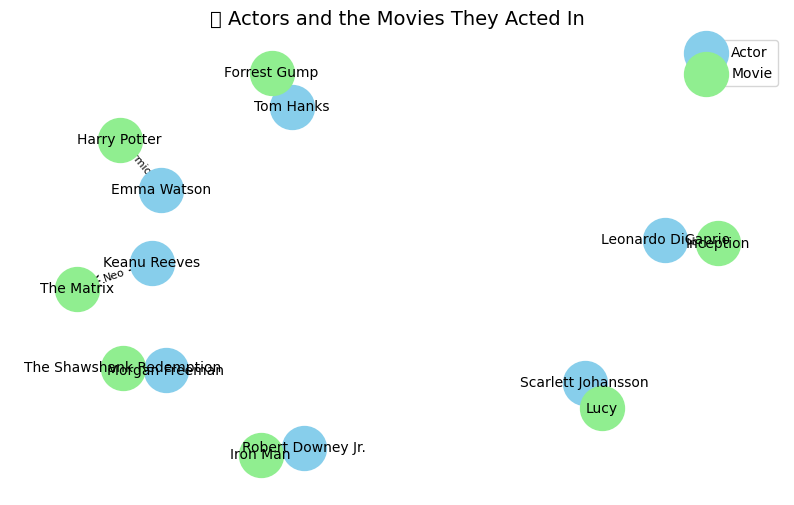

In [ ]:
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)

# Draw nodes with labels
actor_nodes = [n for n, attr in G.nodes(data=True) if attr['label'] == 'actor']
movie_nodes = [n for n, attr in G.nodes(data=True) if attr['label'] == 'movie']

nx.draw_networkx_nodes(G, pos, nodelist=actor_nodes, node_color='skyblue', node_size=1000, label='Actor')
nx.draw_networkx_nodes(G, pos, nodelist=movie_nodes, node_color='lightgreen', node_size=1000, label='Movie')

nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10)

# Draw edge labels (roles)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("🎬 Actors and the Movies They Acted In", fontsize=14)
plt.axis('off')
plt.legend()
plt.show()


In [ ]:
graph.query("""MATCH (m:Movie {title: 'Inception'})
SET m.tagline = 'Your mind is the scene of the crime';""")

graph.query("""MATCH (m:Movie {title: 'Beauty and the Beast'})
SET m.tagline = 'The most beautiful love story ever told';""")

graph.query("""MATCH (m:Movie {title: 'Forrest Gump'})
SET m.tagline = 'Life is like a box of chocolates... you never know what youre gonna get.';""")

[]

In [ ]:
# Add more actors
graph.query("CREATE (:Actor {name: 'Robert Downey Jr.', born: 1965})")
graph.query("CREATE (:Actor {name: 'Scarlett Johansson', born: 1984})")
graph.query("CREATE (:Actor {name: 'Morgan Freeman', born: 1937})")
graph.query("CREATE (:Actor {name: 'Keanu Reeves', born: 1964})")

# Add more movies
graph.query("CREATE (:Movie {title: 'Iron Man', released: 2008})")
graph.query("CREATE (:Movie {title: 'Lucy', released: 2014})")
graph.query("CREATE (:Movie {title: 'The Shawshank Redemption', released: 1994})")
graph.query("CREATE (:Movie {title: 'The Matrix', released: 1999})")

# Add ACTED_IN relationships with roles
graph.query("""
MATCH (a:Actor {name: 'Robert Downey Jr.'}), (m:Movie {title: 'Iron Man'})
CREATE (a)-[:ACTED_IN {role: 'Tony Stark'}]->(m)
""")

graph.query("""
MATCH (a:Actor {name: 'Scarlett Johansson'}), (m:Movie {title: 'Lucy'})
CREATE (a)-[:ACTED_IN {role: 'Lucy'}]->(m)
""")

graph.query("""
MATCH (a:Actor {name: 'Morgan Freeman'}), (m:Movie {title: 'The Shawshank Redemption'})
CREATE (a)-[:ACTED_IN {role: 'Red'}]->(m)
""")

graph.query("""
MATCH (a:Actor {name: 'Keanu Reeves'}), (m:Movie {title: 'The Matrix'})
CREATE (a)-[:ACTED_IN {role: 'Neo'}]->(m)
""")

# Set taglines for new movies
graph.query("""
MATCH (m:Movie {title: 'Iron Man'})
SET m.tagline = 'Heroes aren’t born. They’re built.'
""")

graph.query("""
MATCH (m:Movie {title: 'Lucy'})
SET m.tagline = 'The average person uses 10% of their brain capacity. Imagine what she could do with 100%.'
""")

graph.query("""
MATCH (m:Movie {title: 'The Shawshank Redemption'})
SET m.tagline = 'Fear can hold you prisoner. Hope can set you free.'
""")

graph.query("""
MATCH (m:Movie {title: 'The Matrix'})
SET m.tagline = 'Reality is a thing of the past.'
""")


[]

In [ ]:
graph.query("""
MATCH (m:Movie {title: 'Harry Potter'})
SET m.tagline = 'Let the magic begin.'
""")


[]

In [ ]:
graph.query("CREATE (:Actor {name: 'Daniel Radcliffe', born: 1989})")
graph.query("CREATE (:Actor {name: 'Helena Bonham Carter', born: 1966})")
graph.query("CREATE (:Actor {name: 'Gary Oldman', born: 1958})")
graph.query("CREATE (:Actor {name: 'Matt Damon', born: 1970})")
graph.query("CREATE (:Actor {name: 'Christian Bale', born: 1974})")

[]

In [ ]:
graph.query("CREATE (:Movie {title: 'The Dark Knight', released: 2008})")
graph.query("CREATE (:Movie {title: 'Harry Potter and the Prisoner of Azkaban', released: 2004})")
graph.query("CREATE (:Movie {title: 'Oppenheimer', released: 2023})")
graph.query("CREATE (:Movie {title: 'Good Will Hunting', released: 1997})")

[]

In [ ]:
# Daniel Radcliffe in multiple Harry Potter movies
graph.query("""
MATCH (a:Actor {name: 'Daniel Radcliffe'}), (m:Movie {title: 'Harry Potter'})
CREATE (a)-[:ACTED_IN {role: 'Harry Potter'}]->(m)
""")

graph.query("""
MATCH (a:Actor {name: 'Daniel Radcliffe'}), (m:Movie {title: 'Harry Potter and the Prisoner of Azkaban'})
CREATE (a)-[:ACTED_IN {role: 'Harry Potter'}]->(m)
""")

# Helena Bonham Carter in HP and Oppenheimer
graph.query("""
MATCH (a:Actor {name: 'Helena Bonham Carter'}), (m:Movie {title: 'Harry Potter and the Prisoner of Azkaban'})
CREATE (a)-[:ACTED_IN {role: 'Bellatrix Lestrange'}]->(m)
""")

graph.query("""
MATCH (a:Actor {name: 'Helena Bonham Carter'}), (m:Movie {title: 'Oppenheimer'})
CREATE (a)-[:ACTED_IN {role: 'Psychiatrist'}]->(m)
""")

# Gary Oldman in Dark Knight & HP
graph.query("""
MATCH (a:Actor {name: 'Gary Oldman'}), (m:Movie {title: 'Harry Potter and the Prisoner of Azkaban'})
CREATE (a)-[:ACTED_IN {role: 'Sirius Black'}]->(m)
""")

graph.query("""
MATCH (a:Actor {name: 'Gary Oldman'}), (m:Movie {title: 'The Dark Knight'})
CREATE (a)-[:ACTED_IN {role: 'Commissioner Gordon'}]->(m)
""")

# Christian Bale in Dark Knight & Oppenheimer
graph.query("""
MATCH (a:Actor {name: 'Christian Bale'}), (m:Movie {title: 'The Dark Knight'})
CREATE (a)-[:ACTED_IN {role: 'Bruce Wayne'}]->(m)
""")

graph.query("""
MATCH (a:Actor {name: 'Christian Bale'}), (m:Movie {title: 'Oppenheimer'})
CREATE (a)-[:ACTED_IN {role: 'Physicist'}]->(m)
""")

# Matt Damon in Good Will Hunting & Oppenheimer
graph.query("""
MATCH (a:Actor {name: 'Matt Damon'}), (m:Movie {title: 'Good Will Hunting'})
CREATE (a)-[:ACTED_IN {role: 'Will Hunting'}]->(m)
""")

graph.query("""
MATCH (a:Actor {name: 'Matt Damon'}), (m:Movie {title: 'Oppenheimer'})
CREATE (a)-[:ACTED_IN {role: 'General Leslie Groves'}]->(m)
""")


[]

In [ ]:
graph.query("""
MATCH (m:Movie {title: 'The Dark Knight'})
SET m.tagline = 'Why so serious?'
""")

graph.query("""
MATCH (m:Movie {title: 'Harry Potter and the Prisoner of Azkaban'})
SET m.tagline = 'Something wicked this way comes.'
""")

graph.query("""
MATCH (m:Movie {title: 'Oppenheimer'})
SET m.tagline = 'The world forever changes.'
""")

graph.query("""
MATCH (m:Movie {title: 'Good Will Hunting'})
SET m.tagline = 'Some people can never believe in themselves, until someone believes in them.'
""")


[]

In [ ]:
graph.query("CREATE (:Actor {name: 'Ryan Gosling', born: 1980})")
graph.query("CREATE (:Actor {name: 'Rachel McAdams', born: 1978})")
graph.query("CREATE (:Actor {name: 'Bradley Cooper', born: 1975})")
graph.query("CREATE (:Actor {name: 'Zach Galifianakis', born: 1969})")
graph.query("CREATE (:Actor {name: 'Russell Crowe', born: 1964})")
graph.query("CREATE (:Actor {name: 'Vera Farmiga', born: 1973})")
graph.query("CREATE (:Actor {name: 'Jesse Eisenberg', born: 1983})")
graph.query("CREATE (:Actor {name: 'Emma Stone', born: 1988})")
graph.query("CREATE (:Actor {name: 'Chadwick Boseman', born: 1976})")
graph.query("CREATE (:Actor {name: 'Tom Holland', born: 1996})")


[]

In [ ]:
movies = [
    ("Interstellar", 2014, "Mankind was born on Earth. It was never meant to die here."),
    ("The Notebook", 2004, "Behind every great love is a great story."),
    ("The Hangover", 2009, "Some guys just can’t handle Vegas."),
    ("Gladiator", 2000, "What we do in life echoes in eternity."),
    ("The Wolf of Wall Street", 2013, "The story of a man who had everything. And lost it all."),
    ("The Conjuring", 2013, "Based on the true case files of the Warrens."),
    ("The Social Network", 2010, "You don’t get to 500 million friends without making a few enemies."),
    ("La La Land", 2016, "Here’s to the fools who dream."),
    ("Black Panther", 2018, "Wakanda Forever."),
    ("Catch Me If You Can", 2002, "The true story of a real fake.")
]

for title, year, tagline in movies:
    graph.query(f"""
    CREATE (m:Movie {{title: '{title}', released: {year}, tagline: '{tagline}'}})
    """)


In [ ]:
connections = [
    ("Matthew McConaughey", "Interstellar", "Cooper"),
    ("Ryan Gosling", "The Notebook", "Noah"),
    ("Rachel McAdams", "The Notebook", "Allie"),
    ("Bradley Cooper", "The Hangover", "Phil"),
    ("Zach Galifianakis", "The Hangover", "Alan"),
    ("Russell Crowe", "Gladiator", "Maximus"),
    ("Leonardo DiCaprio", "The Wolf of Wall Street", "Jordan Belfort"),
    ("Vera Farmiga", "The Conjuring", "Lorraine Warren"),
    ("Jesse Eisenberg", "The Social Network", "Mark Zuckerberg"),
    ("Emma Stone", "La La Land", "Mia"),
    ("Ryan Gosling", "La La Land", "Sebastian"),
    ("Chadwick Boseman", "Black Panther", "T\\'Challa"),
    ("Tom Holland", "Black Panther", "Peter Parker"),
    ("Leonardo DiCaprio", "Catch Me If You Can", "Frank Abagnale Jr."),
    ("Tom Hanks", "Catch Me If You Can", "Carl Hanratty")
]

for actor, movie, role in connections:
    graph.query(f"""
    MATCH (a:Actor {{name: '{actor}'}}), (m:Movie {{title: '{movie}'}})
    CREATE (a)-[:ACTED_IN {{role: '{role}'}}]->(m)
    """)
